# **SIAM UQ24 MT5: PyDMD - Dynamic Mode Decomposition with Python**

**Abstract:** PyDMD is a Python package designed for Dynamic Mode Decomposition (DMD), a data-driven method used for analyzing and extracting spatiotemporal coherent structures from time-varying datasets. The package implements many extensions to handle noisy data, impose structure on the learned operators, and provide uncertainty estimates. PyDMD has a comprehensive and user-friendly interface, making it a valuable tool for researchers, engineers, and data scientists working in various fields. After this mini tutorial, participants will be able to use all the main functionalities of the package, exploit Bagging-Optimized Dynamic Mode Decomposition (BOP-DMD) for uncertainty quantification, and develop new DMD classes.

## **Part 0: Installing PyDMD**

To ensure that you are working with the most recent version of PyDMD, we recommend that users install directly from the [Github source code](https://github.com/PyDMD/PyDMD).

One can do so by running the following line of code:

In [ ]:
!pip install git+https://github.com/PyDMD/PyDMD.git

  Cloning https://github.com/PyDMD/PyDMD.git to /tmp/pip-req-build-twji3t0u
  Running command git clone --filter=blob:none --quiet https://github.com/PyDMD/PyDMD.git /tmp/pip-req-build-twji3t0u
  Resolved https://github.com/PyDMD/PyDMD.git to commit 7f4aa774b718c7ff57f2573b72420291e3bcd3a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## **Part 1: Basic PyDMD Usage**

We begin our tutorial by applying DMD to a simple synthetic data set.

By the end of this section of the tutorial, users should be able to...
- Build and fit basic `DMD` models.
- Access and understand crucial `DMD` model attributes.
- Visualize DMD results with the `plot_summary` function.

Run the following block of code to import `numpy`, `matplotlib.pyplot`, and a handful of helper functions that we will be providing.

In [ ]:
# Be sure to install numpy and matplotlib if needed.
# !pip install numpy
# !pip install matplotlib

import numpy as np
import matplotlib.pyplot as plt

def compute_error(actual, truth):
    """
    Args:
        actual = numpy.ndarray of computed values
        truth = numpy.ndarray of expected values
    Returns:
        Relative error as a percentage
    """
    return 100 * np.linalg.norm(truth - actual) / np.linalg.norm(truth)

def plot_data(data, tgrid, xgrid, title):
    """
    Plot 2-D data on a specified grid.

    Args:
        data = 2-D numpy.ndarray of data to plot
        tgrid = temporal grid that the given data is defined on
        xgrid = spatial grid that the given data is defined on
        title = plot title
    """
    plt.figure(figsize=(4, 2))
    plt.title(title)
    plt.pcolor(tgrid, xgrid, data.T)
    plt.xlabel("Time (t)")
    plt.ylabel("Space (x)")
    plt.show()

## **Part 1a: Make the toy data set**

We start by examining data derived from the system $f(x, t) = f_1(x, t) + f_2(x, t)$, where<br>

$f_1(x, t) = \text{sech}(x + 3) e^{i 2.3 t}$<br>
$f_2(x, t) = 2\text{sech}(x) \text{tanh}(x) e^{i 2.8 t}$.

We specifically examine the domain $x \in [-5, 5]$ across times $t \in [0, 4\pi]$.

We also use $n = 65$ collocation points across $m = 129$ time steps (all evenly-spaced).

Run the code below to build this particular data set.

In [ ]:
def f1(x, t):
    """
    Spatiotemporal mode 1.
    """
    return 1.0 / np.cosh(x + 3) * np.exp(1j * 2.3 * t)

def f2(x, t):
    """
    Spatiotemporal mode 2.
    """
    return 2.0 / np.cosh(x) * np.tanh(x) * np.exp(1j * 2.8 * t)

nx = 65 # number of grid points along space dimension
nt = 129 # number of grid points along time dimension

# Define the space and time grid for data collection.
x = np.linspace(-5, 5, nx)
t = np.linspace(0, 4 * np.pi, nt)
xgrid, tgrid = np.meshgrid(x, t)
dt = t[1] - t[0] # get the time-step

# Data consists of our 2 spatiotemporal signals.
X1 = f1(xgrid, tgrid).T
X2 = f2(xgrid, tgrid).T
X = X1 + X2
print("Data successfully generated!")
print(f"Data dimensions in (space, time): {X.shape}")

Data successfully generated!
Data dimensions in (space, time): (65, 129)


We now visualize the data with the following code.

Notice how both the real and imaginary components of this data set contain rich dynamics.

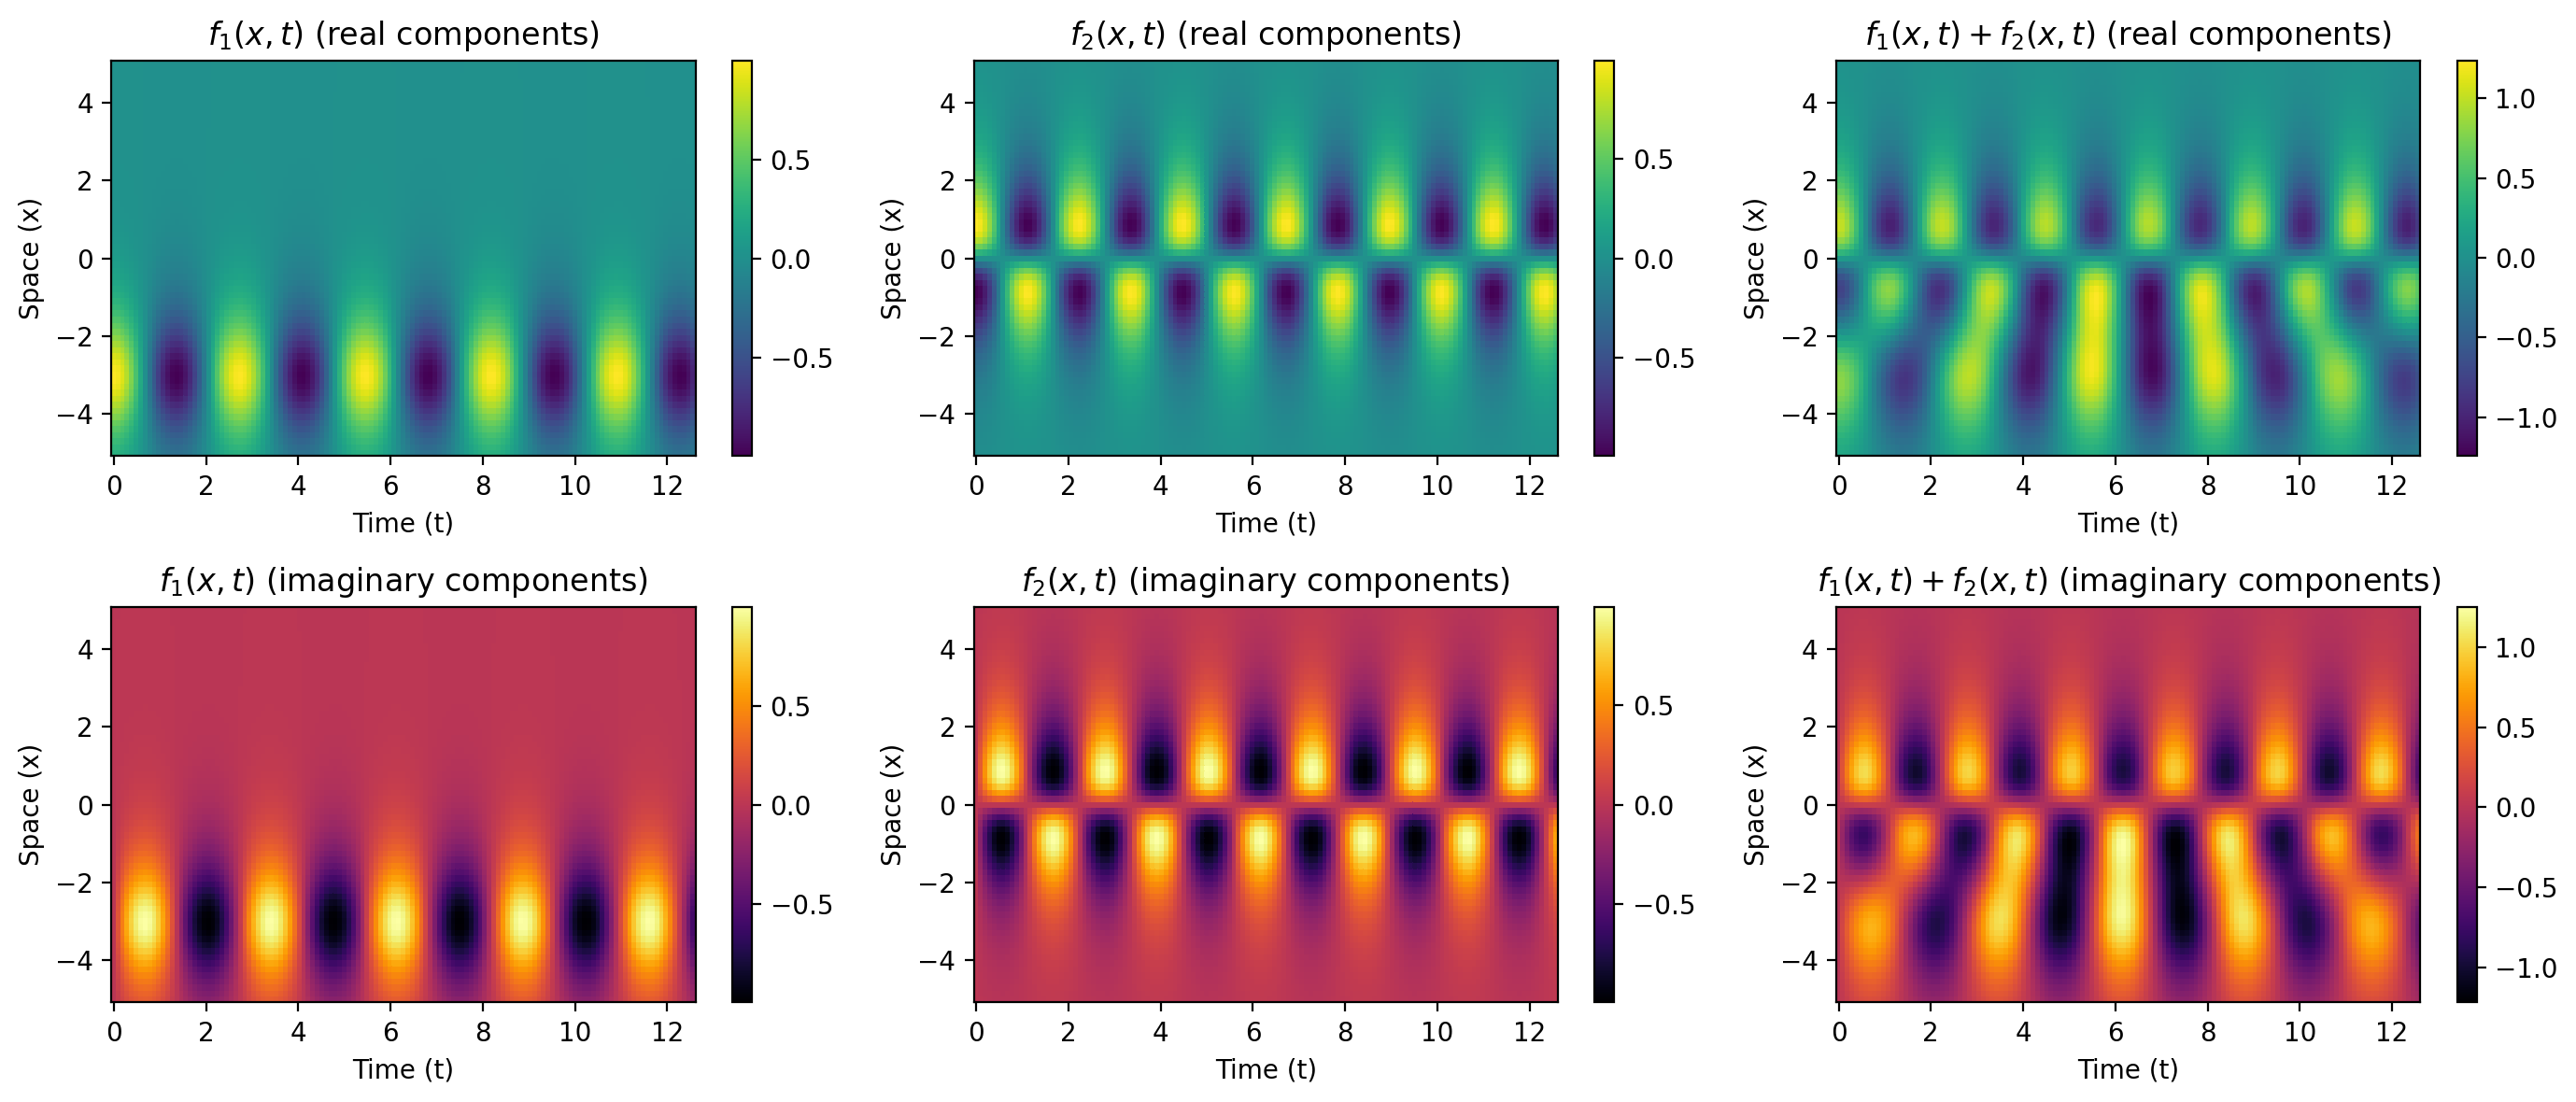

In [ ]:
# Visualize the data.
titles = ["$f_1(x,t)$", "$f_2(x,t)$", "$f_1(x,t) + f_2(x,t)$"]
data = [X1, X2, X]

fig = plt.figure(figsize=(14, 6), dpi=200)
for i, (title, d) in enumerate(zip(titles, data)):
    # Plot the real components of the data.
    plt.subplot(2, 3, i + 1)
    plt.title(title + " (real components)")
    plt.pcolor(tgrid, xgrid, d.real.T)
    plt.xlabel("Time (t)")
    plt.ylabel("Space (x)")
    plt.colorbar()
    # Plot the imaginary components of the data.
    plt.subplot(2, 3, i + 4)
    plt.title(title + " (imaginary components)")
    plt.pcolor(tgrid, xgrid, d.imag.T, cmap="inferno")
    plt.xlabel("Time (t)")
    plt.ylabel("Space (x)")
    plt.colorbar()

plt.tight_layout()
plt.show()

To give users a better sense of what this data set looks like, we provide the following animation of the data.

Feel free to skip this cell if you simply wish to proceed.

Moviepy - Building video data.mp4.
Moviepy - Writing video data.mp4



Moviepy - Done !
Moviepy - video ready data.mp4


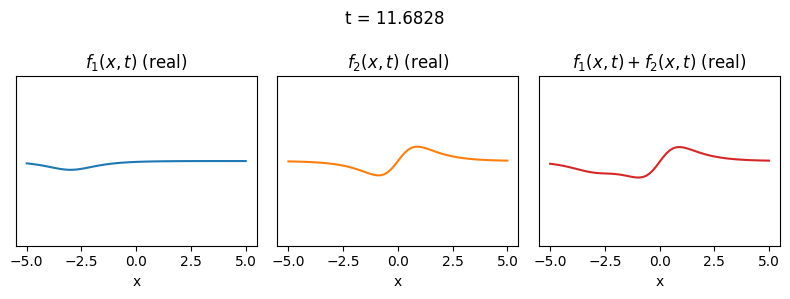

In [ ]:
# Be sure to install moviepy if needed.
# !pip install moviepy

from moviepy.editor import *
from moviepy.video.io.bindings import mplfig_to_npimage

colors = ["tab:blue", "tab:orange", "tab:red"]
titles = ["$f_1(x,t)$", "$f_2(x,t)$", "$f_1(x,t) + f_2(x,t)$"]

def make_video(X, X1, X2, T, name):
    fps = int(X.shape[1] / T)

    def make_frame(ti):
        time_index = int(fps * ti)
        for i, (ax, mat) in enumerate(zip([ax1, ax2, ax3], [X1, X2, X])):
            ax.clear()
            plt.suptitle(f"t = {np.round(t[time_index], decimals=5)}")
            ax.plot(x, mat[:, time_index].real, c=colors[i])
            ax.set_ylim([-1.6, 1.6])
            ax.set_title(f"{titles[i]} (real)")
            ax.set_xlabel("x")
            ax.set_yticks([])
        plt.tight_layout()
        return mplfig_to_npimage(fig)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3))
    animation = VideoClip(make_frame, duration=T)
    animation.write_videofile(name, fps=fps)

# Make the mp4 file.
make_video(X, X1, X2, T=10, name="data.mp4")

# Play the mp4 file.
ipython_display("data.mp4")

## **Part 1b: Apply DMD**

We now apply DMD to this data set. Recall that for data in the form

$$
\mathbf{X} =
\begin{bmatrix}
| & | & & | \\
\mathbf{x}(t_1) &
\mathbf{x}(t_2) &
\dots &
\mathbf{x}(t_m) \\
| & | & & |
\end{bmatrix} \in \mathbb{R}^{n \times m},
$$

where we have $m$ snapshots of $n$-dimensional data, the DMD algorithm seeks the following decomposition:

$$
\mathbf{X}
\approx
\begin{bmatrix}
    | & & | \\
    \boldsymbol{\phi}_1 & \dots & \boldsymbol{\phi}_r \\
    | & & |
\end{bmatrix}
\begin{bmatrix}
    b_1 \\ & \ddots \\ && b_r
\end{bmatrix}
\begin{bmatrix}
    e^{\omega_1 t_1} & \dots & e^{\omega_1 t_m} \\
    \vdots & \ddots & \vdots \\
    e^{\omega_r t_1} & \dots & e^{\omega_r t_m}
\end{bmatrix}
= \mathbf{\Phi} \text{diag}(\mathbf{b})\mathbf{T}(\boldsymbol{\omega}),
$$

where the columns of $\mathbf{\Phi}$ give spatial modes, the entries of $\boldsymbol{\omega}$ give temporal frequencies, and the entries of $\mathbf{b}$ give mode amplitudes.

We start by applying the [exact DMD](https://doi.org/10.3934/jcd.2014.1.391) algorithm to our data, which is implemented by the `DMD` module. [[source]](https://github.com/PyDMD/PyDMD/blob/7f4aa774b718c7ff57f2573b72420291e3bcd3a4/pydmd/dmd.py#L13)

To do so, we simply build a `DMD` model and invoke the `fit` method, which requires the data snapshots $\mathbf{X}$. We demonstrate this process below.

Feel free to dismiss the condition number warning -- this process will work out fine despite the condition number.

Also notice that we use `svd_rank=2` since our data consists of $r = 2$ spatiotemporal modes.

In [ ]:
from pydmd import DMD

dmd = DMD(svd_rank=2)
dmd.fit(X)

matrix, or regularization methods.
  warnings.warn(



### **Exercise 1a:**

Print the `eigs` attribute of our fitted `DMD` model.

These are what we call the "discrete-time eigenvalues", denoted as $\lambda_i$.
- Use the discrete-time eigenvalues to compute and print the "continuous-time eigenvalues" $\omega_i = \log(\lambda_i) / \Delta t$.
- How do the continuous-time eigenvalues relate to the temporal parameters of our toy data set?

In [ ]:
# TODO:
# Hint: The time-step is stored in the variable dt!
print(???)
print(???)

### **Exercise 1b:**

Print the shape of the `modes` and `dynamics` attributes of our fitted `DMD` model.

Note that the `modes` attribute contains the entries of $\mathbf{\Phi}$, while the `dynamics` attribute contains the entries of $\mathbf{T}(\boldsymbol{\omega})$.
- How do these shapes relate to the `svd_rank` and the dimensions of the input data?
- Plot the **real components** of the `modes` and `dynamics`. How do they relate to the components of our toy system?

In [ ]:
# TODO:
print(???)
print(???)

plt.figure(figsize=(8, 5))
plt.subplot(2, 2, 1)
# PLOT THE MODES HERE
plt.plot(???, ???)
plt.plot(???, ???)
# ^^^^^^^^^^^^^^^^^^^
plt.subplot(2, 2, 2)
# PLOT THE DYNAMICS HERE
plt.plot(???, ???)
plt.plot(???, ???)
# ^^^^^^^^^^^^^^^^^^^^^^
plt.subplot(2, 2, 3)
plt.plot(x, 1.0 / np.cosh(x + 3), c="k", label="sech(x + 3)")
plt.plot(x, 2.0 / np.cosh(x) * np.tanh(x), c="r", label="2sech(x)tanh(x)")
plt.xlabel("x")
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(t, np.cos(2.3 * t), c="k", label="cos(2.3t)")
plt.plot(t, np.cos(2.8 * t), c="r", label="cos(2.8t)")
plt.xlabel("t")
plt.legend()
plt.tight_layout()
plt.show()

### **Exercise 1c:**

Print the `amplitudes` attribute of our fitted DMD model.

Note that this attribute refers to the entries of the vector $\mathbf{b}$.
- Now print the modulus of the `amplitudes`.
- Which spatiotemporal mode contributes more to the data?

In [ ]:
# TODO:
print(???)
print(???)

We have now examined all of the key components of the DMD representation. Nice!

However, instead of grabbing all of these attributes individually, you can visualize all of these attributes at once with a simple call to the `plot_summary` function found in the `pydmd.plotter` suite. We demonstrate a simple call to this function below. Note that the function requires a fitted PyDMD model, along with any necessary or relevant plotting parameters. [[source]](https://github.com/PyDMD/PyDMD/blob/7f4aa774b718c7ff57f2573b72420291e3bcd3a4/pydmd/plotter.py#L537)

Notice that on top of plotting our eigenvalues, modes, and dynamics, `plot_summary` also gives us the following:
- The singular value spectrum of the data matrix $\mathbf{X}$ is provided. From this, we can tell that this data requires a decomposition with $r = 2$.
- Eigenvalues, modes, and dynamics are color-coordinated to indicate the pairings that make up each spatiotemporal mode.
- Eigenvalue marker sizes reflect the corresponding amplitude of the spatiotemporal mode.

  warnings.warn(



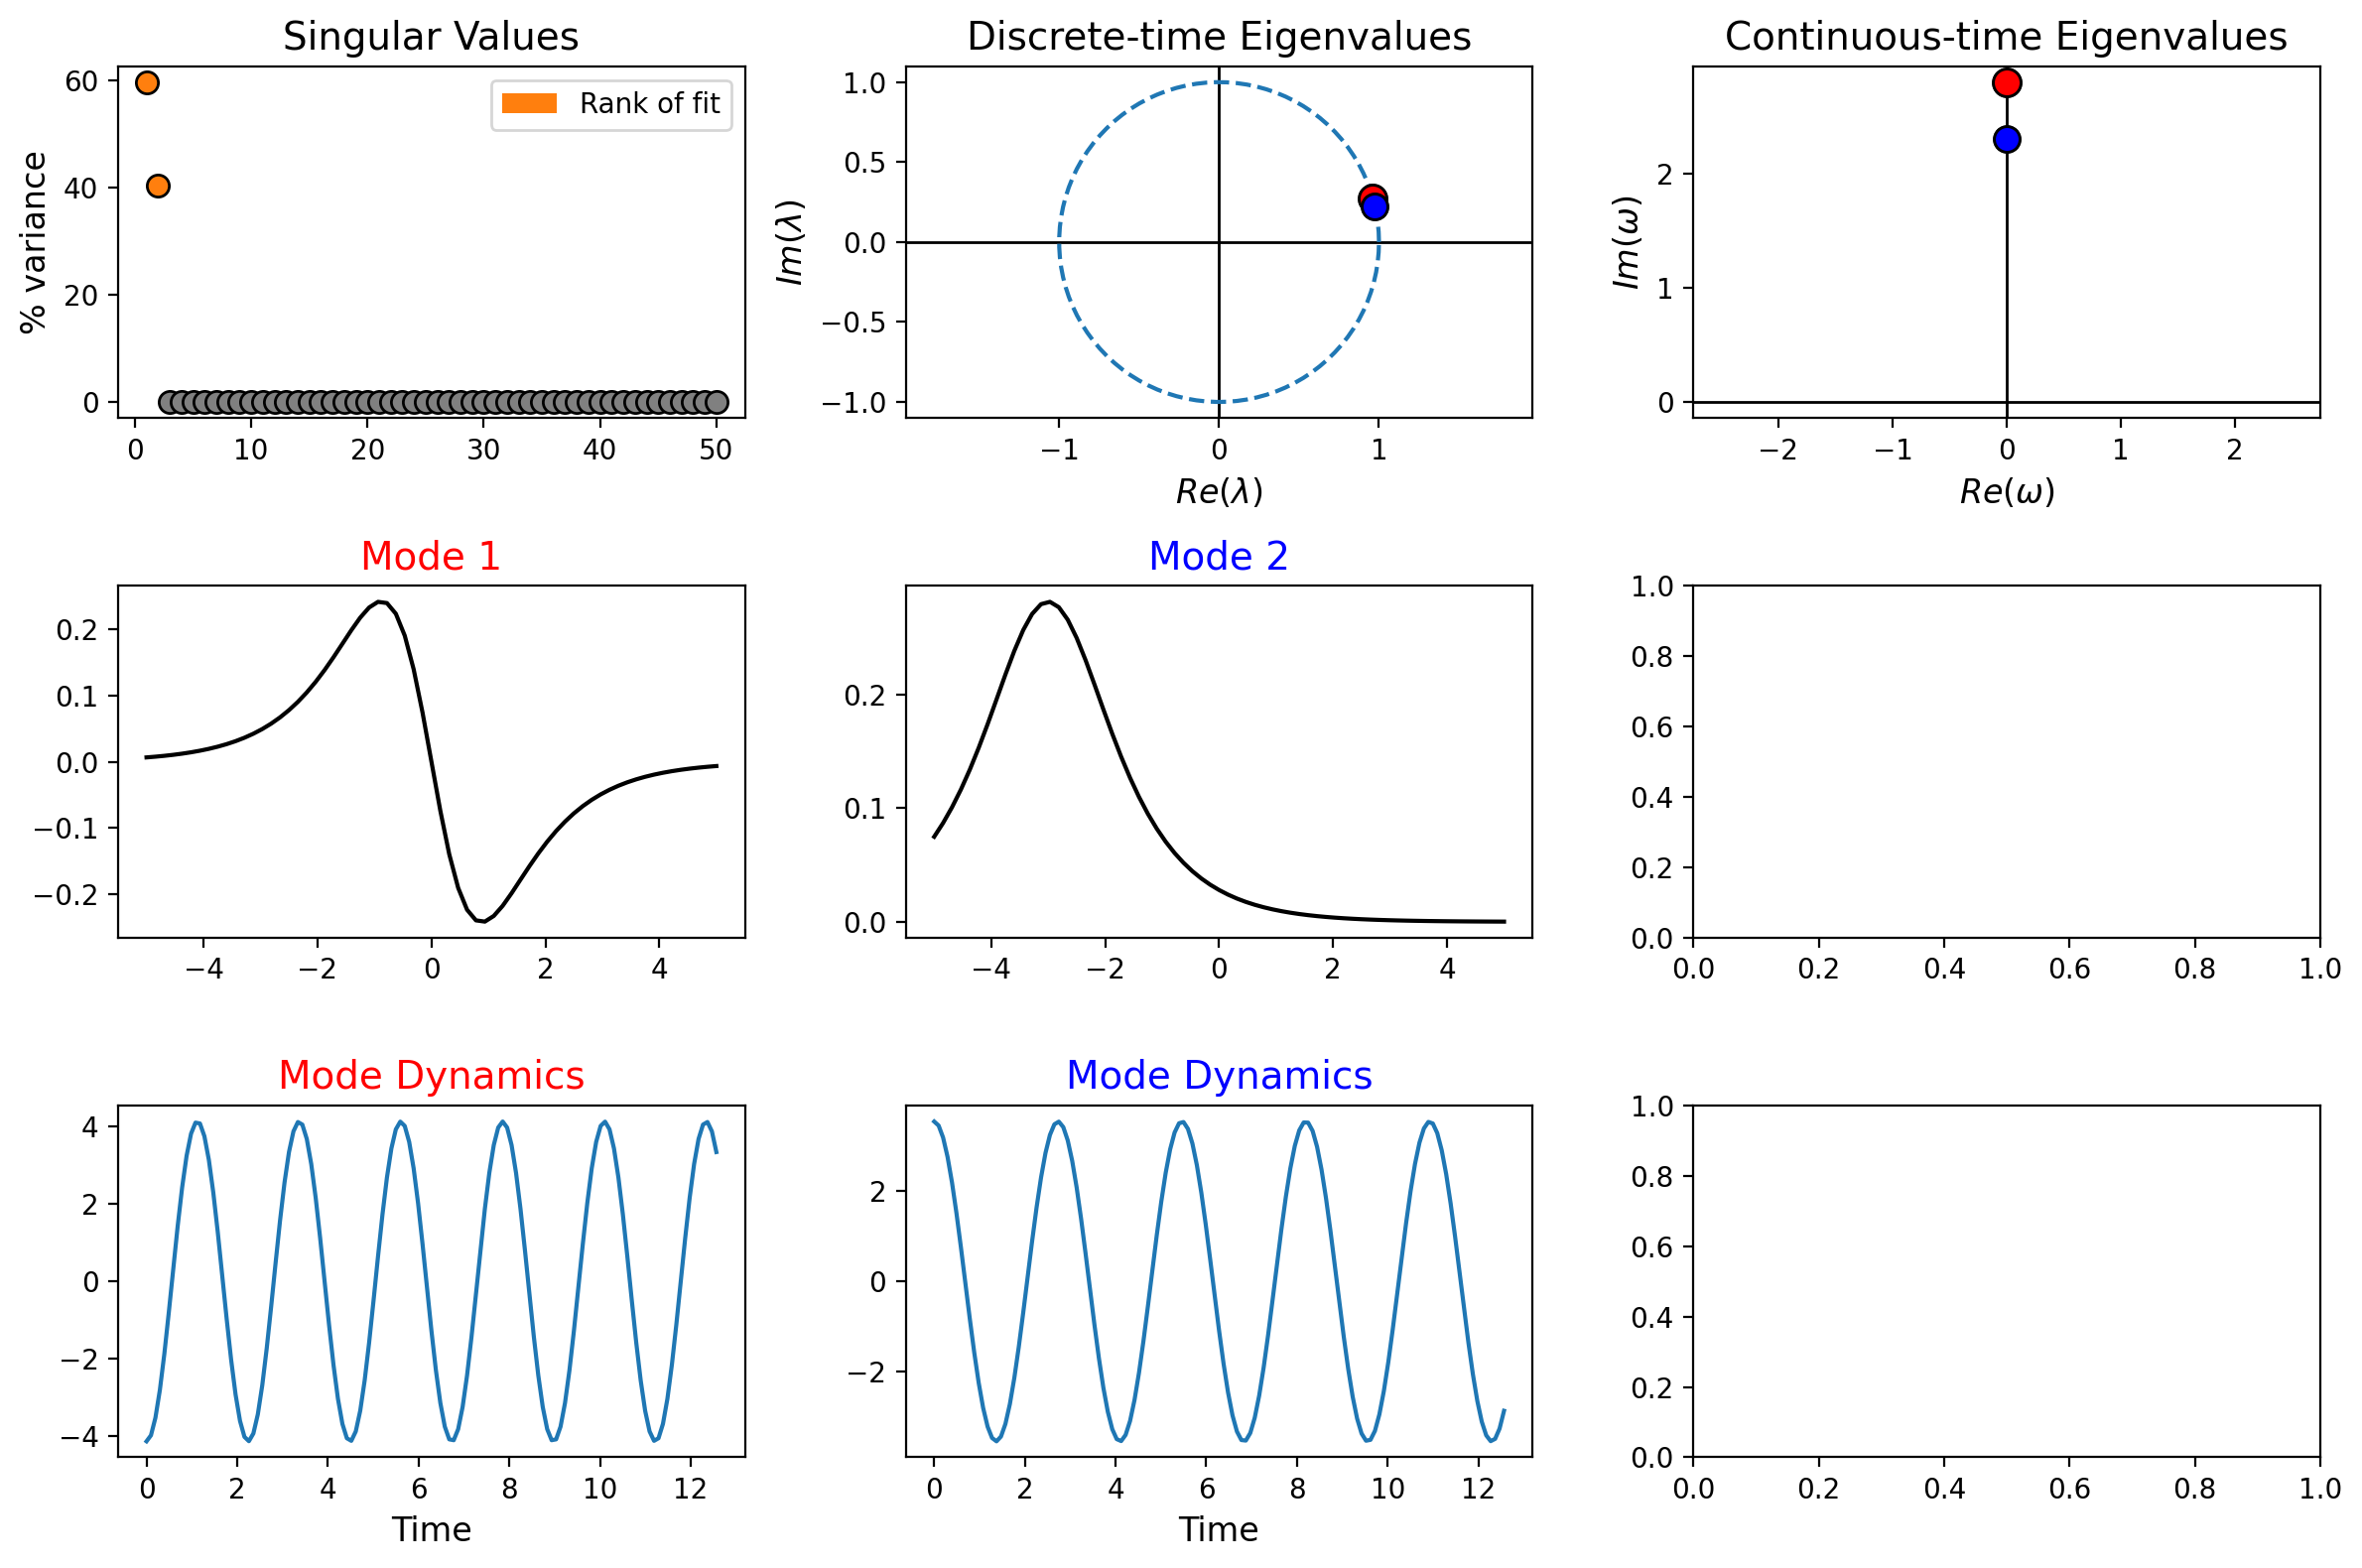

In [ ]:
from pydmd.plotter import plot_summary

plot_summary(dmd, x=x, t=t)

Fitted PyDMD models also possess a `reconstructed_data` attribute, which uses the computed DMD diagnostics in order to attempt to reconstruct the original data set. Below, we plot the real components of the reconstruction and print the reconstruction error.

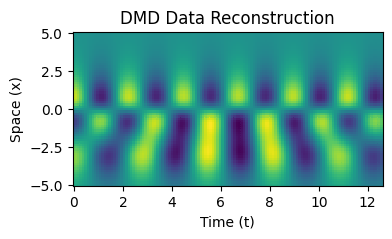

DMD reconstruction error: 5.692869190514756e-12%


In [ ]:
plot_data(dmd.reconstructed_data.real, tgrid, xgrid, "DMD Data Reconstruction")
print(f"DMD reconstruction error: {compute_error(dmd.reconstructed_data, X)}%")

## **Bonus exercises:**
- Reformat the `plot_summary` output. [[source]](https://github.com/PyDMD/PyDMD/blob/7f4aa774b718c7ff57f2573b72420291e3bcd3a4/pydmd/plotter.py#L537)
    - Adjust the size and the resolution of the figure.
    - Plot the singular values with log scaling on the y-axis.
    - Interchange the axes on the continuous-time eigenvalue plot.
    - Change the color of the eigenvalue markers from `"r"`, `"b"` to `"m"`, `"c"`.
- Perform DMD on this data set with rank $r=1$. Are we still able to represent the data with DMD? Why or why not?
- Perform DMD on this data set with rank $r=3$. Are we still able to represent the data with DMD? Why or why not?

In [ ]:
# Bonus exercise workspace:

## **Part 2: Data Preprocessors**

We now make our data set harder to analyze by removing the imaginary components of our data.

By the end of this section of the tutorial, users should be able to...
- Import and use the data preprocessors found in `pydmd.preprocessing`.
- Identify when and why time-delays might be necessary when applying DMD.

First, notice what happens if we attempt to apply the exact same DMD pipeline as before using only the real components of our input data.

Everything falls apart!

matrix, or regularization methods.
  warnings.warn(



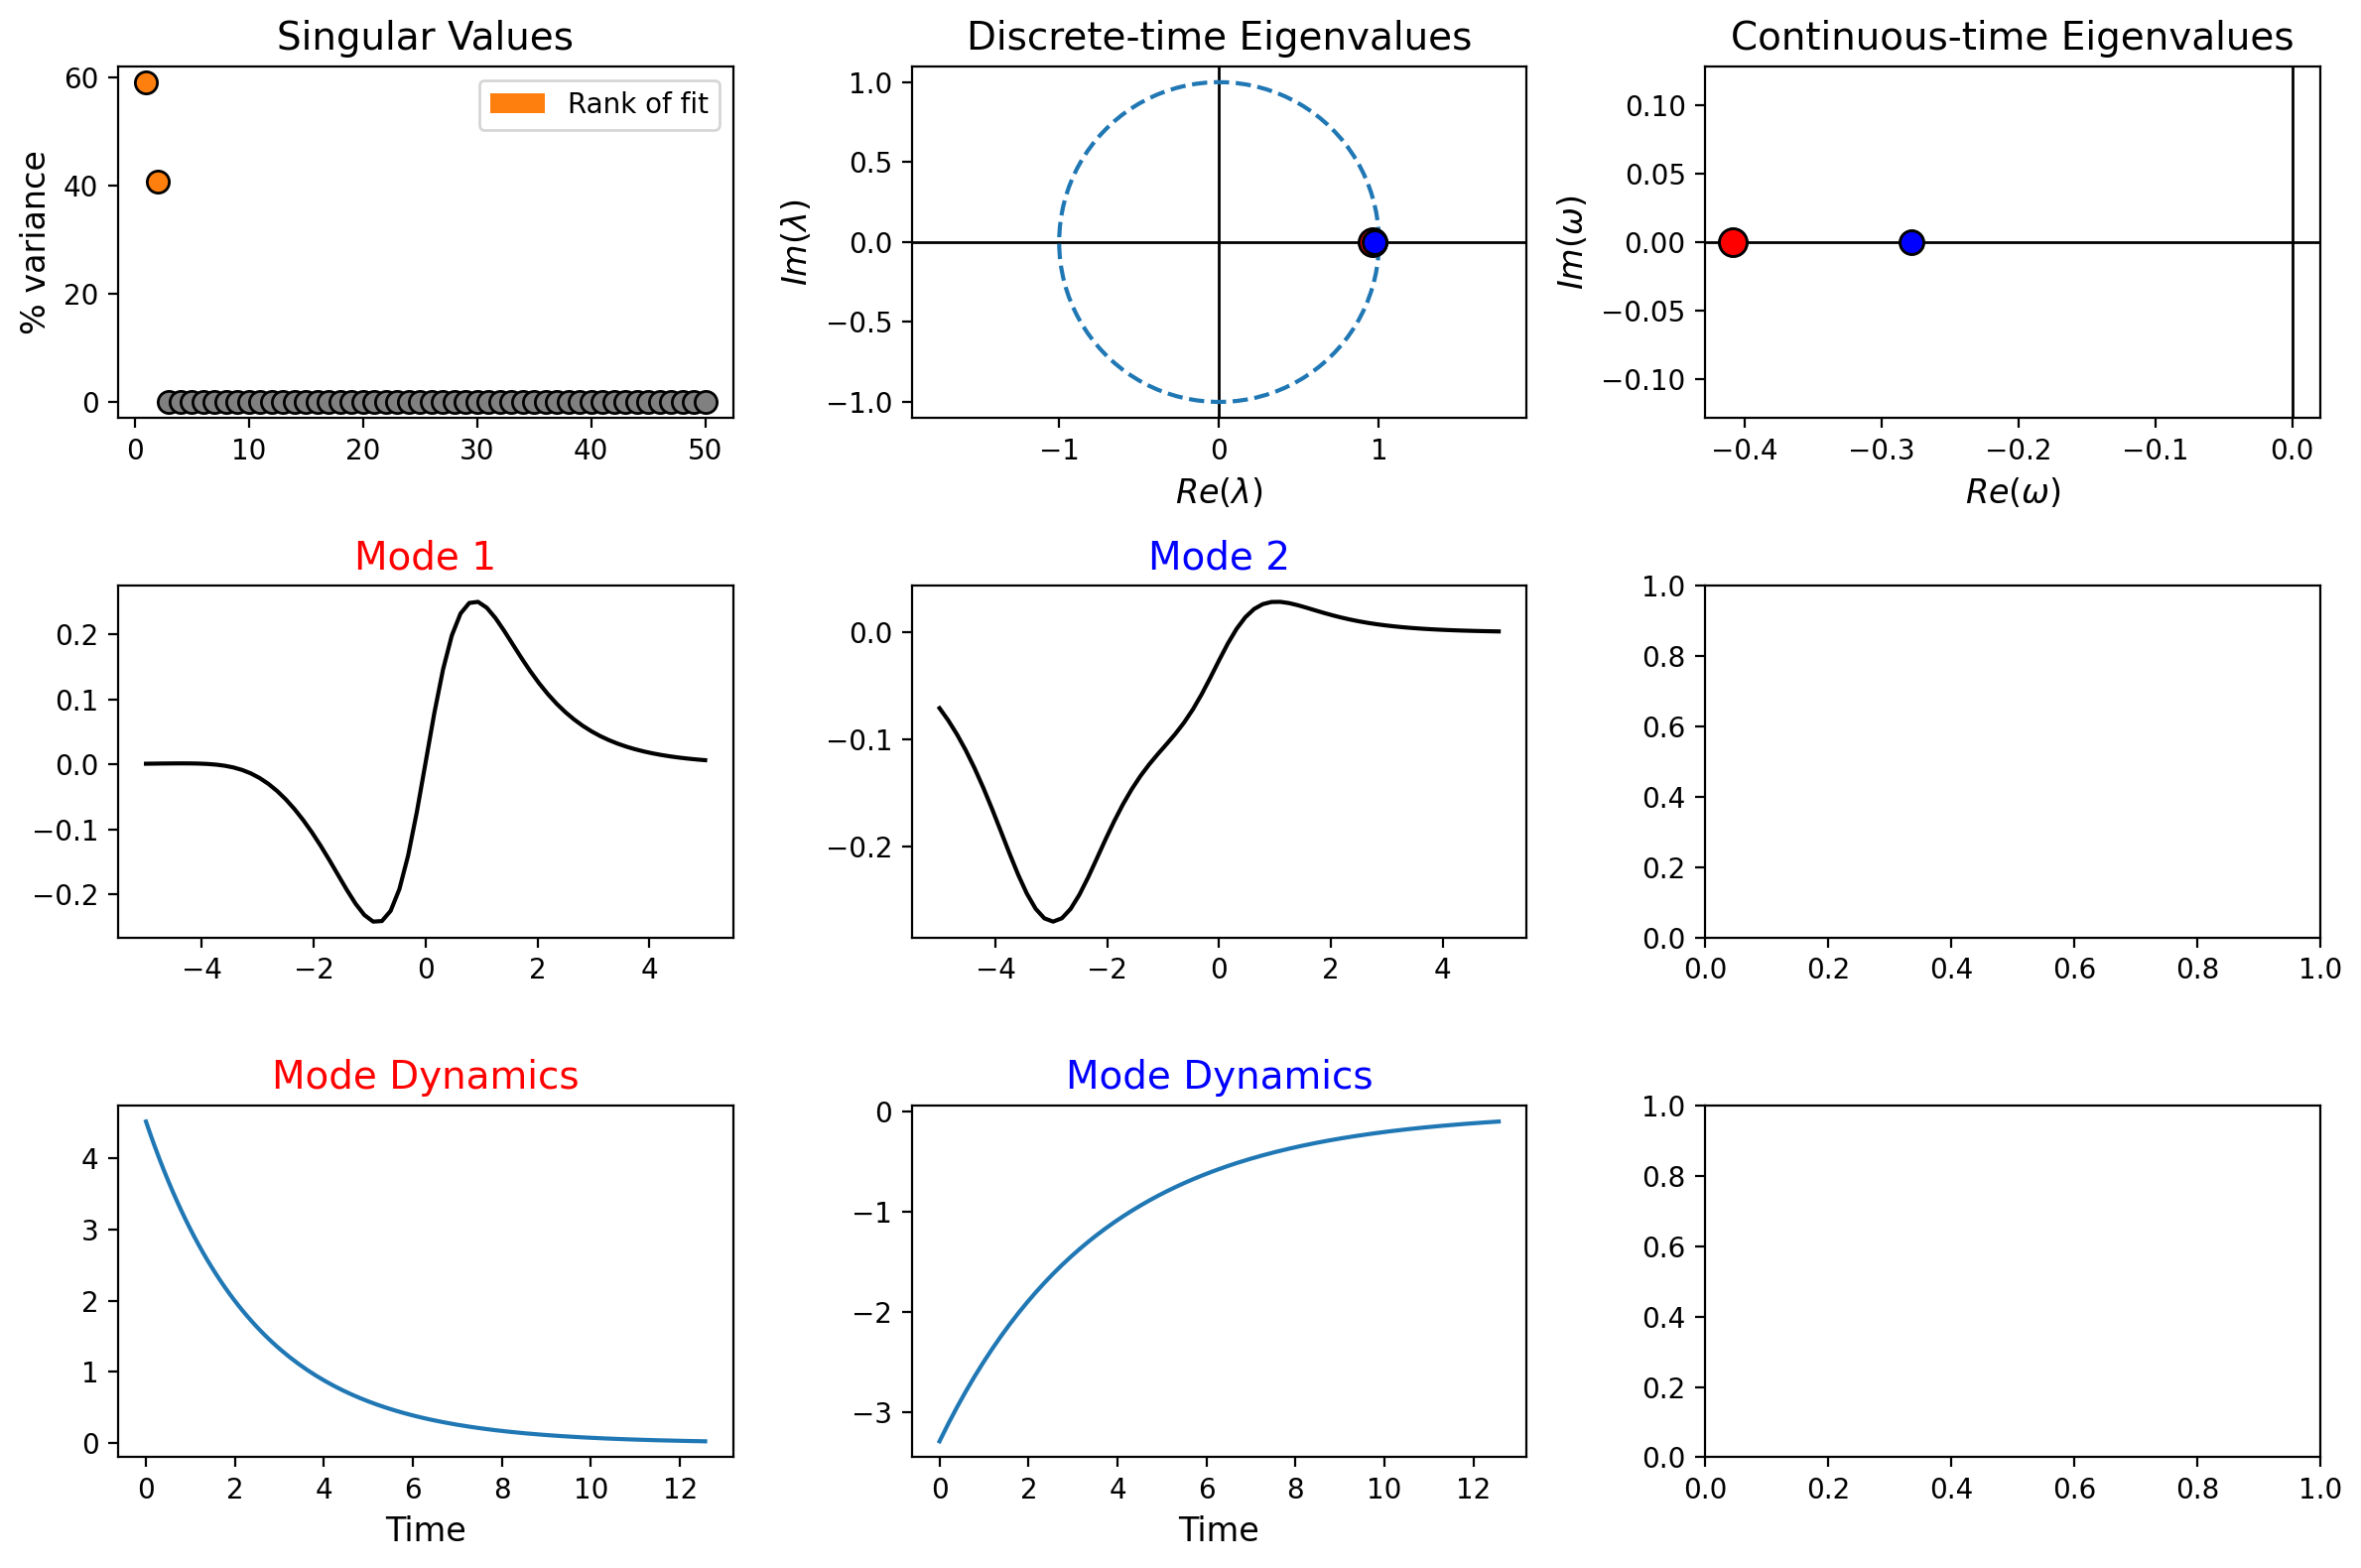

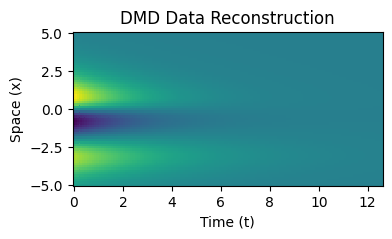

DMD reconstruction error: 106.23062815921615%


In [ ]:
dmd = DMD(svd_rank=2)
dmd.fit(X.real)
plot_summary(dmd, x=x, t=t)

plot_data(dmd.reconstructed_data.real, tgrid, xgrid, "DMD Data Reconstruction")
print(f"DMD reconstruction error: {compute_error(dmd.reconstructed_data, X.real)}%")

What is going on here?

After all, even without the imaginary components, our data still captures all of the major spatial and temporal behaviors of our system.

To get to the bottom of this, consider the rank of our data matrix, using only real components.

In [ ]:
print(f"Data matrix rank with no delays: {np.linalg.matrix_rank(X.real)}")

Data matrix rank with no delays: 2


### **Exercise 2a:**

Now, apply time-delays to the real data matrix with the `pseudo_hankel_matrix` tool found in `pydmd.utils`. [[source]](https://github.com/PyDMD/PyDMD/blob/7f4aa774b718c7ff57f2573b72420291e3bcd3a4/pydmd/utils.py#L271)

Recall that using time-delays with $d$ delays involves converting a data matrix

$$
\mathbf{X} =
\begin{bmatrix}
\mathbf{x}(t_1) &
\mathbf{x}(t_2) &
\dots &
\mathbf{x}(t_m)
\end{bmatrix} \in \mathbb{R}^{n \times m}
$$

into a hankel matrix

$$
\mathbf{X} =
\begin{bmatrix}
\mathbf{x}(t_1) & \mathbf{x}(t_2) & \dots & \mathbf{x}(t_p) \\
\mathbf{x}(t_2) & \mathbf{x}(t_3) & \dots & \mathbf{x}(t_{p+1}) \\
\vdots & \vdots & \ddots & \vdots \\
\mathbf{x}(t_d) & \mathbf{x}(t_{d+1}) & \dots & \mathbf{x}(t_m)
\end{bmatrix} \in \mathbb{R}^{nd \times p}.
$$

This gives us a way of augmenting our data with additional variables or observables at the expense of some data snapshots.

- What is the rank of the **real components** of the data after applying $d=2$ delays?
- What about after applying $d = 3, 4,$ or $10$ delays?

In [ ]:
from pydmd.utils import pseudo_hankel_matrix

# TODO:
rank_d2 = ???
rank_d3 = ???
rank_d4 = ???
rank_d10 = ???

# This prints results -- no need to do anything here.
print(f"Data matrix rank after 2 delays: {rank_d2}")
print(f"Data matrix rank after 3 delays: {rank_d3}")
print(f"Data matrix rank after 4 delays: {rank_d4}")
print(f"Data matrix rank after 10 delays: {rank_d10}")

Notice how by deploying some number of time-delays, we increase the rank of our data matrix, which notifies us that time-delays actually reveal some crucial latent variables hidden within our data. What this then tells us is that when dealing with only the real components of this data set, **we must use some amount of time-delays if we hope to get a good DMD representation.**

Although we could just apply time-delays and then feed this data to a `DMD` object, another option is to use a data preprocessor from the `pydmd.preprocessing` suite, which will preprocess and postprocess our data for us. We explore these tools below.

### **Exercise 2b:**

Use the `hankel_preprocessing` tool found in `pydmd.preprocessing` to first apply time-delays to the data, and then apply DMD. [[source]](https://github.com/PyDMD/PyDMD/blob/7f4aa774b718c7ff57f2573b72420291e3bcd3a4/pydmd/preprocessing/hankel.py#L17)

To demonstrate how preprocessors work, we provide some starter code in the cell below. Notice how preprocessing tools wrap around PyDMD modules, but the modules still encode the DMD algorithm of choice.

- Below, you must choose an appropriate rank $r$ for the DMD fit. Based on the rank of the data after applying time-delays, what should $r$ be?

- You must also choose an appropriate number of delays $d$ to use. Based on how many delays were necessary in order to maximize the rank of the data matrix, what should $d$ be? Perhaps there are many correct answers?

- Whatever number of delays $d$ that you use, be sure to feed it to the `plot_summary` function as well. The function uses this parameter in order to collapse spatial modes across delays so that the plotted modes make more sense.

In [ ]:
from pydmd.preprocessing import hankel_preprocessing

# TODO:
dmd = DMD(svd_rank=???)
delay_dmd = hankel_preprocessing(dmd, ???)
delay_dmd.fit(X.real)
plot_summary(delay_dmd, x=x, t=dt, ???)

# This plots the reconstruction and the error -- no need to do anything here.
plot_data(delay_dmd.reconstructed_data.real, tgrid, xgrid, "Delay DMD Data Reconstruction")
print(f"Delay DMD reconstruction error: {compute_error(delay_dmd.reconstructed_data.real, X.real)}%")

## **Bonus exercises:**
- Try using `plot_summary` to plot the time-delay DMD results again, but without providing the time-delay parameter. What do you notice about the `modes` attribute of a model that has been fitted with time-delay data?
- Notice that in the last `plot_summary` call, we used $\Delta t$ as our `t` argument as opposed to the time vector like we did in Part 1. This is because the `t` argument of `plot_summary` can be either. Using $\Delta t$ is just more convenient in the time-delay case since we sacrifice some number of snapshots and hence some number of time points when we use time-delays. With that in mind, try using `plot_summary` with your time-delay DMD model, but while using a time vector instead of a time-step for `t`. How much do you need to shorten the time vector if you use $d$ time-delays?

In [ ]:
# Bonus exercise workspace:

## **Part 3: Advanced PyDMD Applications**

We now make our data set even harder to analyze by introducing nontrivial amounts of measurement noise.

By the end of this section of the tutorial, users should be able to...

- Build and fit complex BOP-DMD models.
- Model real data sets that are polluted with noise.
- Obtain and visualize UQ metrics for their DMD results.

We begin by defining and visualizing the noisy data set that we will be using during this portion of the tutorial.

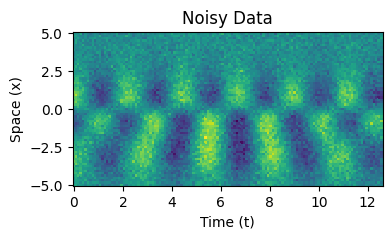

In [ ]:
# Generate noisy, real-valued data.
noise_magnitude = 0.2
noise = noise_magnitude * np.random.randn(*X.shape)
X_noisy = X.real + noise

# Plot the noisy data set.
plot_data(X_noisy, tgrid, xgrid, "Noisy Data")

First, notice that after the introduction of this amount of measurement noise, the results of exact DMD break down completely.

A huge contributing factor to this is the eigenvalues that exact DMD learns. The introduction of noise biases the exact DMD eigenvalues and in turn results in time dynamics that decay over time. **We hence need a better DMD algorithm that can withstand the introduction of noise.**

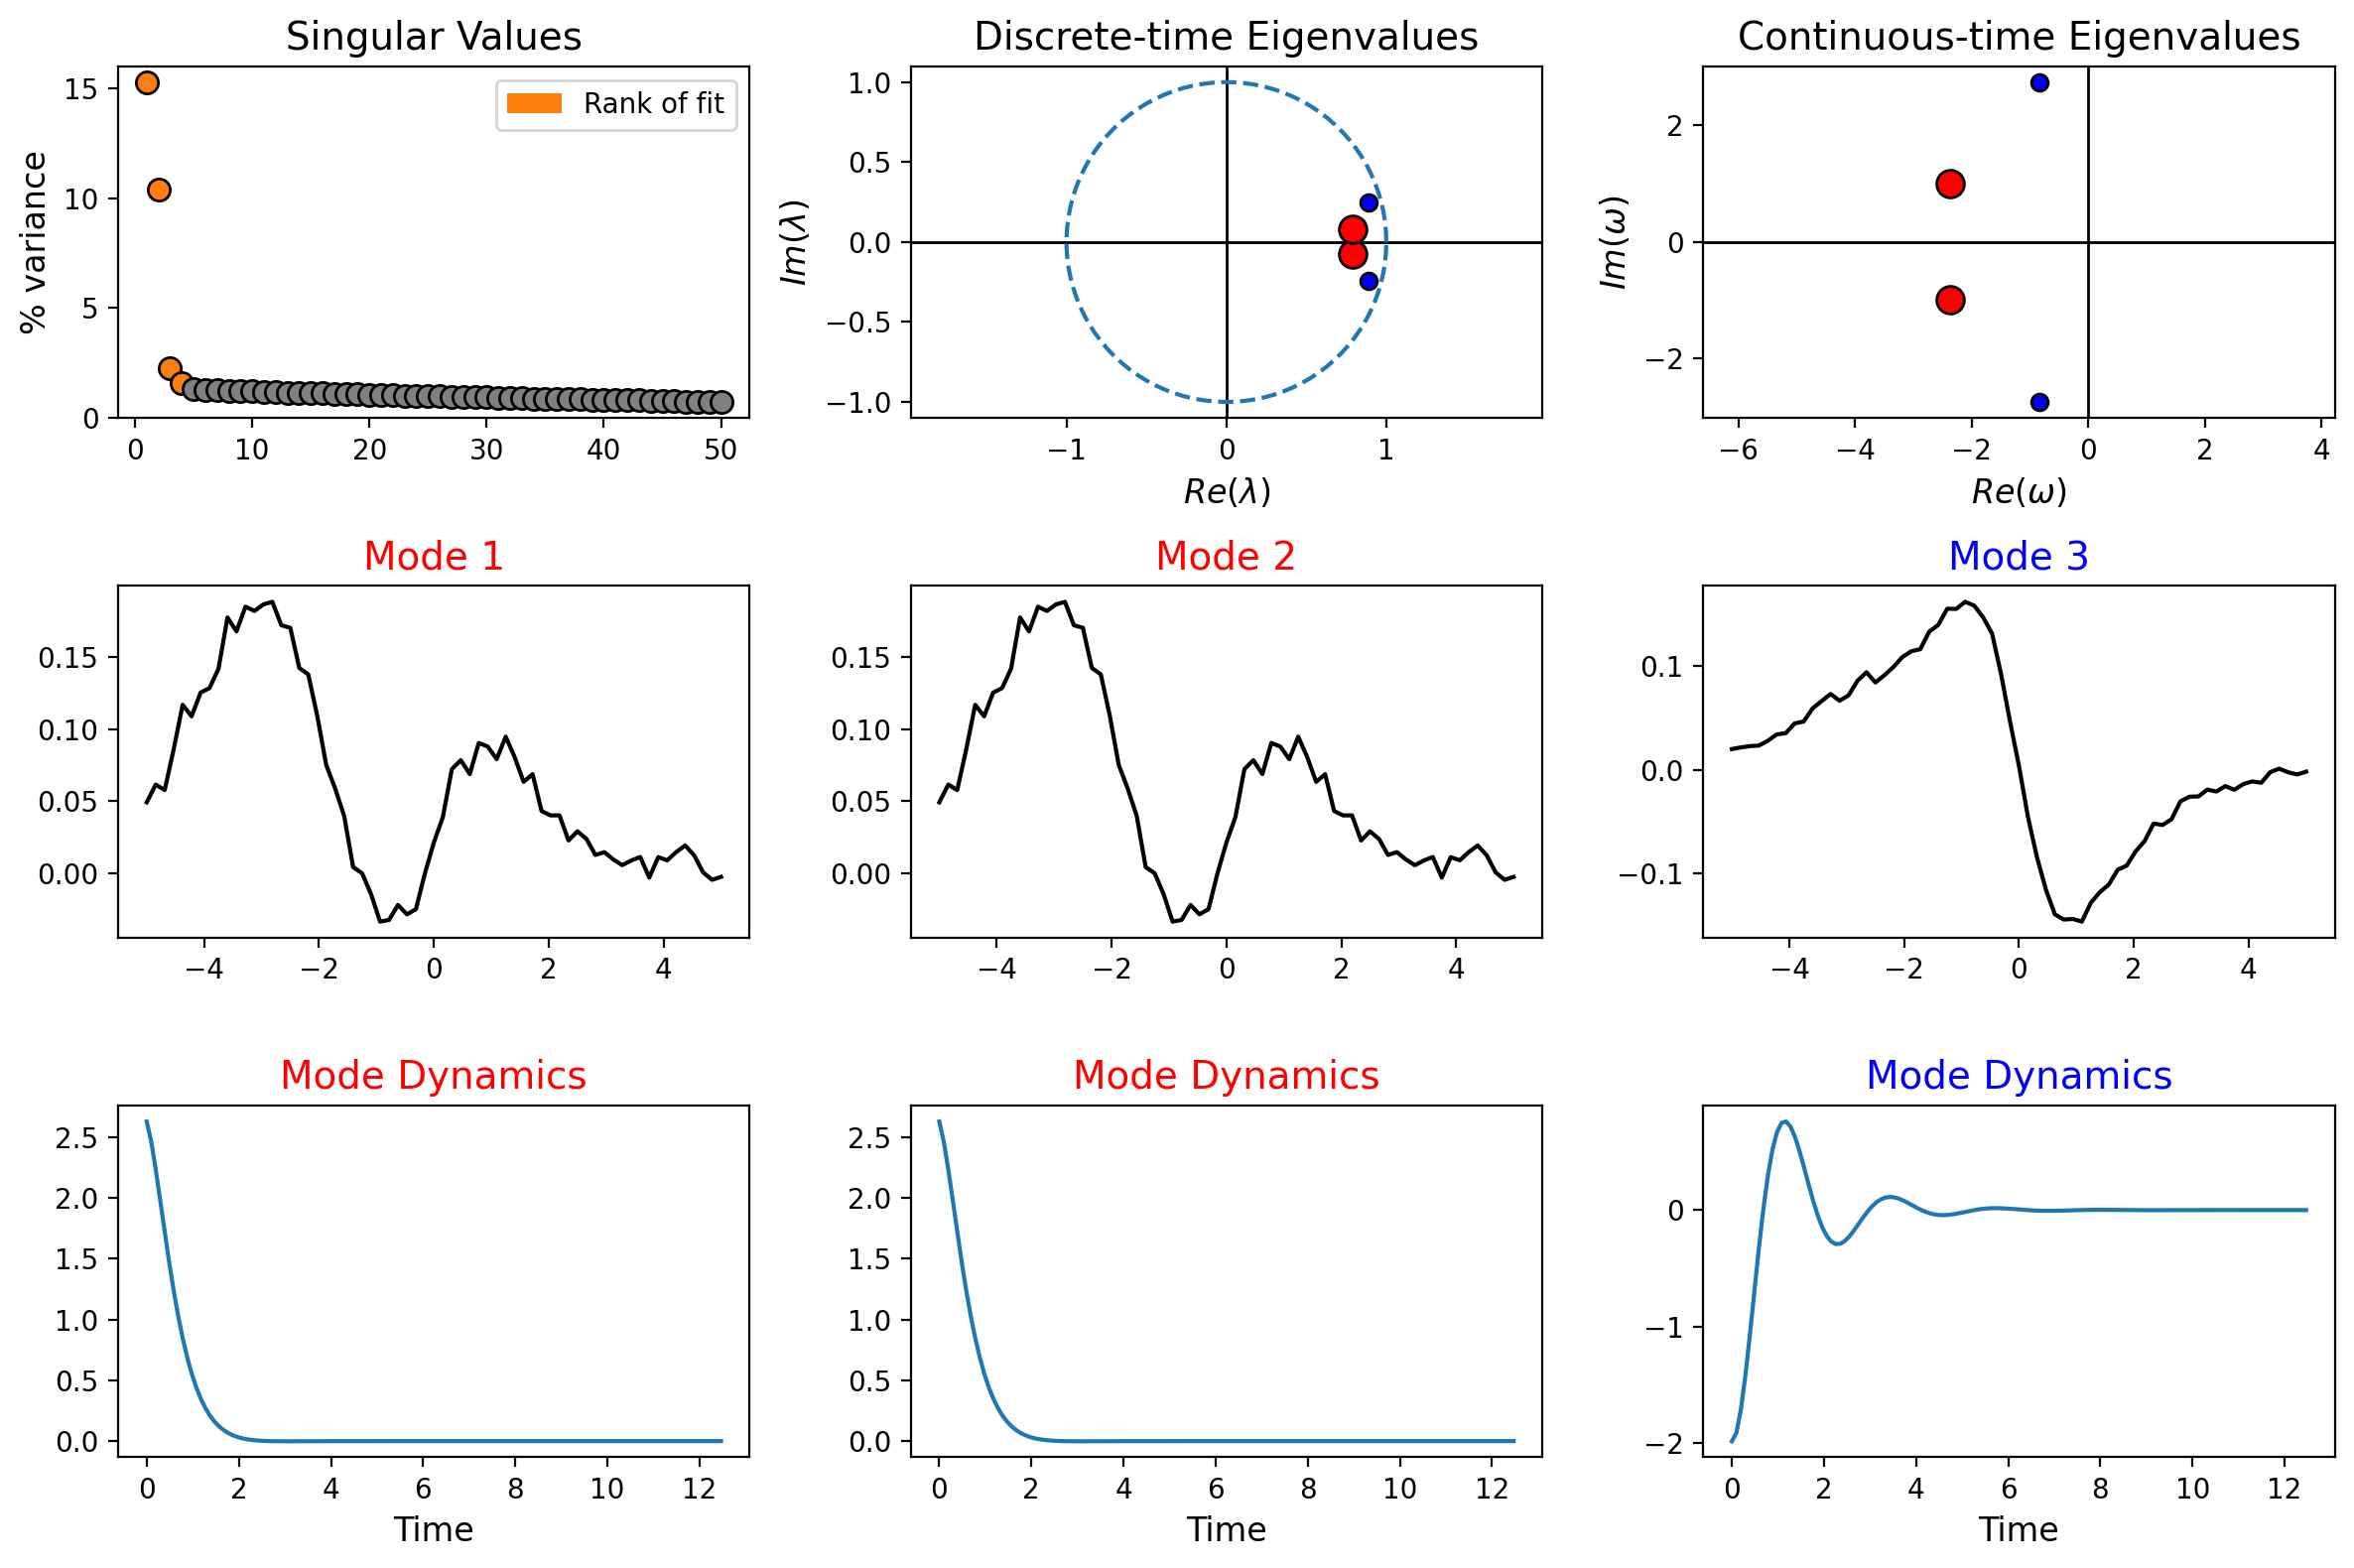

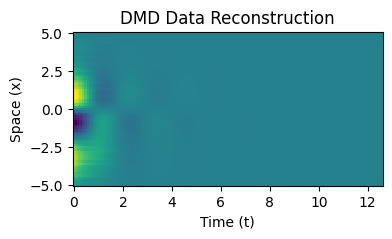

DMD reconstruction error: 98.30829346344017%


In [ ]:
# Build and fit the time-delay DMD model from part 2.
delay_dmd = hankel_preprocessing(DMD(svd_rank=4), d=2)
delay_dmd.fit(X_noisy)
plot_summary(delay_dmd, x=x, t=dt, d=2)

# Error results.
plot_data(delay_dmd.reconstructed_data.real, tgrid, xgrid, "DMD Data Reconstruction")
print(f"DMD reconstruction error: {compute_error(delay_dmd.reconstructed_data, X.real)}%")

In order to deal with this, we fall back on the much more robust [Optimized DMD](https://doi.org/10.1137/M1124176) algorithm.

This algorithm is implemented by the `BOPDMD` module and can be utilized like so. Below, we turn verbosity on in order to view progress of the variable projection algorithm. We also provide code for pairing `BOPDMD` modules with time-delay preprocessing for convenience. [[source]](https://github.com/PyDMD/PyDMD/blob/7f4aa774b718c7ff57f2573b72420291e3bcd3a4/pydmd/bopdmd.py#L867)

Step 1 Error 0.0802685975313148 Lambda 0.3333333333333333
Step 2 Error 0.08008832876362945 Lambda 0.1111111111111111
Step 3 Error 0.08008831357673017 Lambda 0.037037037037037035
Step 4 Error 0.08008831357579824 Lambda 0.012345679012345678
Step 5 Error 0.08008831357579808 Lambda 0.004115226337448559
Stall detected: error reduced by less than 1e-12 times the error at the previous step. Iteration 5. Current error 0.08008831357579808. Consider increasing tol or decreasing eps_stall.


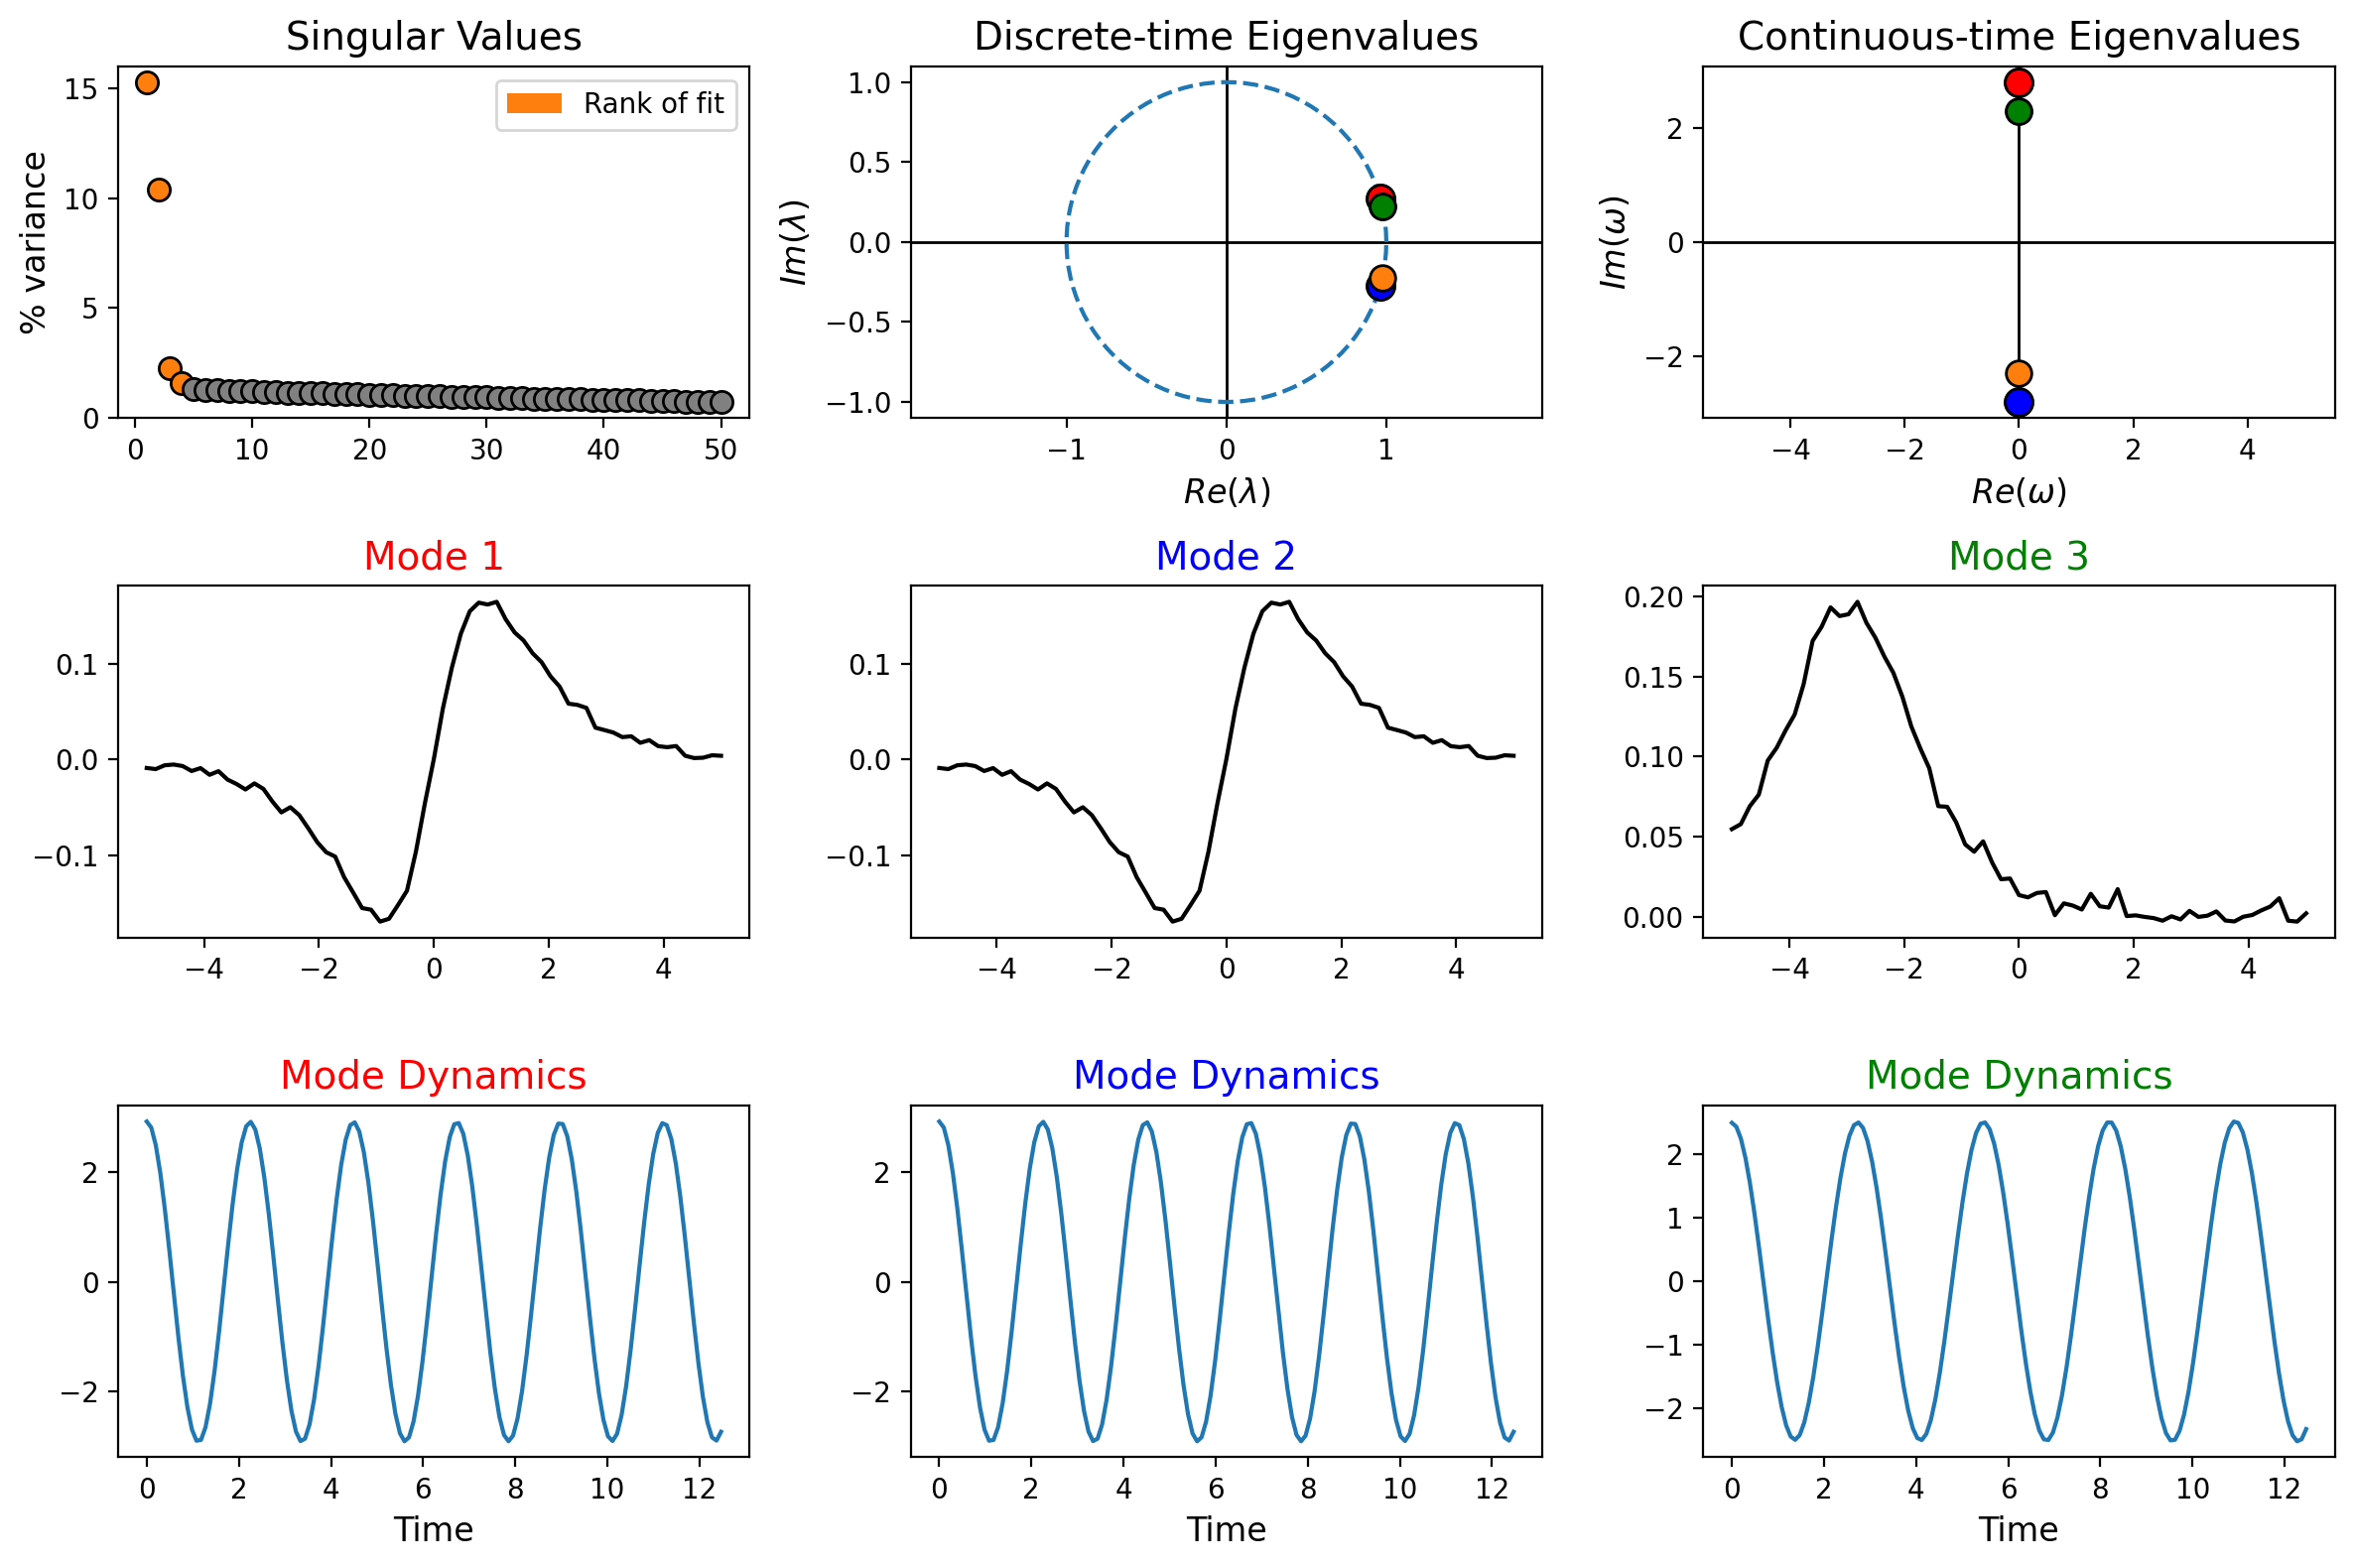

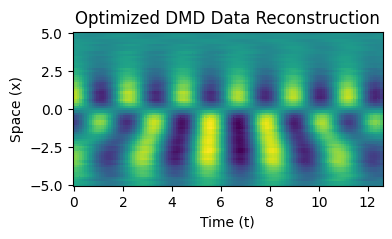

Optimized DMD reconstruction error: 7.497715036933723%


In [ ]:
from pydmd import BOPDMD

# Build the Optimized DMD model.
optdmd = BOPDMD(svd_rank=4, varpro_opts_dict={"verbose": True})

# Pair Optimized DMD with time-delay.
d = 2
delay_optdmd = hankel_preprocessing(optdmd, d=d)
delay_optdmd.fit(X_noisy, t=t[:-d+1]) # Optimized DMD needs times for fitting
plot_summary(delay_optdmd, x=x, t=dt, d=d)

# Error results.
plot_data(delay_optdmd.reconstructed_data.real, tgrid, xgrid, "Optimized DMD Data Reconstruction")
print(f"Optimized DMD reconstruction error: {compute_error(delay_optdmd.reconstructed_data, X.real)}%")

Much better! Now let's explore even more features and possibilities with the `BOPDMD` module.

First, we introduce bagging, which elevates us from Optimized DMD to Bagging, Optimized DMD [(BOP-DMD)](https://doi.org/10.1098/rsta.2021.0199).

### **Exerise 3a:**

Fit a `BOPDMD` [[source]](https://github.com/PyDMD/PyDMD/blob/7f4aa774b718c7ff57f2573b72420291e3bcd3a4/pydmd/bopdmd.py#L867) model that does the following:
- Use 100 trials where each trial uses 90% of the total available data.
- Change some variable projection parameters:
    - Turn verbosity on to track progress.
    - Set the convergence tolerance to 0.1 so that we converge easier.

In [ ]:
# TODO:
bopdmd = BOPDMD(
    svd_rank=4,
    ???
)

# Preprocessing and plotting code from before -- no need to do anything here.
d = 2
delay_bopdmd = hankel_preprocessing(bopdmd, d=d)
delay_bopdmd.fit(X_noisy, t=t[:-d+1])
plot_summary(delay_bopdmd, x=x, t=dt, d=d)
plot_data(delay_bopdmd.reconstructed_data.real, tgrid, xgrid, "BOP-DMD Data Reconstruction")
print(f"BOP-DMD reconstruction error: {compute_error(delay_bopdmd.reconstructed_data, X.real)}%")

In addition to the `modes`, `eigs`, and `amplitudes` attributes, `BOPDMD` models that use multiple bagging trials also possess the following:
- `modes_std` - mode standard deviation across all trials
- `eigenvalues_std` - eigenvalue standard deviation across all trials
- `amplitudes_std` - amplitude standard deviation across all trials

Hence the `modes`, `eigs`, and `amplitudes` attributes store the average results across all trials.

### **Exerise 3b:**

Using the time-delay BOP-DMD model fitted in the previous exercise, plot the modes and eigenvalues alongside their UQ metrics.
- To reorient ourselves a bit, print the shape of the `modes` attribute and the `modes_std` attribute of our model. Notice that the two matrices are the same shape, as the `modes_std` attribute encodes the standard deviation across all modes and collocation points. Also notice how the dimension of the modes is $n \cdot d$ due to time-delays.
- Plot the modes alongside the mode standard deviations. Be sure to plot them separately, as the standard deviation will be very small compared to the mean values. You can use the provided `plot_mode_uq` function to do this. Whether you collapse the modes across delays or not is up to you.
- Repeat this using the computed eigenvalues. For the standard deviation plotting, you can use the provided `plot_eig_uq` function.


In [ ]:
# Plotting code -- feel free to use and/or edit!

def plot_mode_uq(modes, modes_std, d=None):
    """
    Plot BOP-DMD modes alongside their standard deviations.

    modes = (d*n, r) numpy.ndarray of average BOP-DMD modes.
    modes_std = (d*n, r) numpy.ndarray of mode standard deviations.
    d = number of delays to average across.
    """
    plt.figure(figsize=(12, 4), dpi=200)
    for i, (mode, mode_std) in enumerate(zip(modes.real.T, modes_std.T)):
        # Collapse the results across time-delays.
        if d is not None:
            mode = np.average(mode.reshape(d, nx), axis=0)
            mode_std = np.average(mode_std.reshape(d, nx), axis=0)

        plt.subplot(2, 4, i + 1)
        # Plot the average mode.
        plt.title("Average Mode")
        plt.plot(mode)
        # Plot the mode standard deviation.
        plt.subplot(2, 4, i + 5)
        plt.title("Mode Standard Deviation")
        plt.plot(mode_std, c="tab:red")

    plt.suptitle("DMD Modes")
    plt.tight_layout()
    plt.show()

def plot_eig_uq(eigs, eigs_std):
    """
    Plot BOP-DMD eigenvalues against true eigenvalues and 2 standard deviations.

    Args:
        eigs = (r,) numpy.ndarray of average BOP-DMD eigenvalues.
        eigs_std = (r,) numpy.ndarray of eigenvalue standard deviations.
    """
    # Define the true DMD eigenvalues.
    eigs_true = np.array([2.8j, 2.3j, -2.3j, -2.8j])

    fig, ax = plt.subplots(figsize=(6, 2), dpi=200)
    for e, std in zip(eigs, eigs_std):
        # Plot 2 standard deviations.
        circle_1 = plt.Circle((e.imag, e.real), 2 * std, color="b", alpha=0.2)
        ax.add_patch(circle_1)
        # Plot 1 standard deviation.
        circle_2 = plt.Circle((e.imag, e.real), std, color="b", alpha=0.5)
        ax.add_patch(circle_2)

    # Plot the average eigenvalues.
    ax.plot(eigs.imag, eigs.real, "o", c="b", label="BOP-DMD")
    # Plot the true eigenvalues.
    ax.plot(eigs_true.imag, eigs_true.real, "x", c="k", label="Truth")
    plt.title("DMD Eigenvalues")
    plt.xlabel("$Im(\omega)$")
    plt.ylabel("$Re(\omega)$")
    plt.legend()
    plt.show()

In [ ]:
# TODO:
print(???)
print(???)
plot_mode_uq(???)

print(???)
print(???)
plot_eig_uq(???)

### **Exerise 3c:**

Repeat the entire BOP-DMD analysis from exercises 3a and 3b. That is...

- Use the real, noisy data set,
- Use time-delay preprocessing,
- Use a BOP-DMD model with the parameters from 3a, and
- Plot the UQ metrics for the resulting modes and the eigenvalues.

Only this time, constrain the eigenvalues to be imaginary **AND** to come in perfect complex conjugate pairs. [[source]](https://github.com/PyDMD/PyDMD/blob/7f4aa774b718c7ff57f2573b72420291e3bcd3a4/pydmd/bopdmd.py#L867)

In [ ]:
# TODO:

## **Bonus exercises:**
- Try adjusting the level of added Gaussian noise on the data. How does increasing or decreasing the magnitude of the noise impact the BOP-DMD results, including our UQ metrics?
- Try adjusting some parameters of BOP-DMD. For example, what happens if you change the number of trials used or the trial size? Is there a trial size that is too small? How do these parameters impact the BOP-DMD results, as well as our UQ metrics?

In [ ]:
# Bonus exercise workspace:

For more information, see our full set of [tutorials](https://github.com/PyDMD/PyDMD/tree/master/tutorials) and our [arXiv paper](https://doi.org/10.48550/arXiv.2402.07463).